In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import label

import gc
gc.enable()

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Train and test directories
train_image_dir = "E:/train_v2"
test_image_dir = "E:/test_v2"

In [4]:
# Getting into train directory
train_images = os.listdir(train_image_dir)
train_images.sort()
print(f"Total of {len(train_images)} images in train directory.\nHere is how first five train_images looks like:- {train_images[:5]}")

Total of 192556 images in train directory.
Here is how first five train_images looks like:- ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg', '000194a2d.jpg', '0001b1832.jpg']


In [5]:
# Using for loop to generate different images to understand how data looks like
# plt.figure(figsize=(15,15))
# plt.suptitle('TRAIN IMAGES\n', weight = 'bold', fontsize = 15, color = 'r')
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(imread(train_image_dir + "/" + train_images[i]))
#     plt.title(f"{train_images[i]}", weight = 'bold')
#     plt.axis('off')
# plt.tight_layout()

In [6]:
# Train ships segmented masks
masks = pd.read_csv('C:/Users/krish/Downloads/train_ship_segmentations_v2.csv')
masks.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [7]:
row_rle = ['10 1', 
           '4 1 2 0 4 1', 
           '3 1 4 0 3 1', 
           '2 1 6 0 2 1',
           '1 1 2 0 1 1 2 0 1 1 2 0 1 1', 
           '1 1 8 0 1 1', 
           '3 1 1 0 2 1 1 0 3 1', 
           '2 1 1 0 1 1 2 0 1 1 1 0 2 1', 
           '1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1', 
           '10 1',
           'Total']

pixels = [len(row.split(" ")) for row in row_rle if row != 'Total']
sum_pixels = np.array(pixels).sum()
pixels.append(sum_pixels)

data = {
    'Row - RLE' : row_rle,
    'Pixels' : pixels
}

rle_df = pd.DataFrame(data)
rle_df.index+=1
rle_df


,Row - RLE,Pixels
1,10 1,2
2,4 1 2 0 4 1,6
3,3 1 4 0 3 1,6
4,2 1 6 0 2 1,6
5,1 1 2 0 1 1 2 0 1 1 2 0 1 1,14
6,1 1 8 0 1 1,6
7,3 1 1 0 2 1 1 0 3 1,10
8,2 1 1 0 1 1 2 0 1 1 1 0 2 1,14
9,1 1 1 0 1 1 1 0 2 1 1 0 1 1 1 0 1 1,18
10,10 1,2


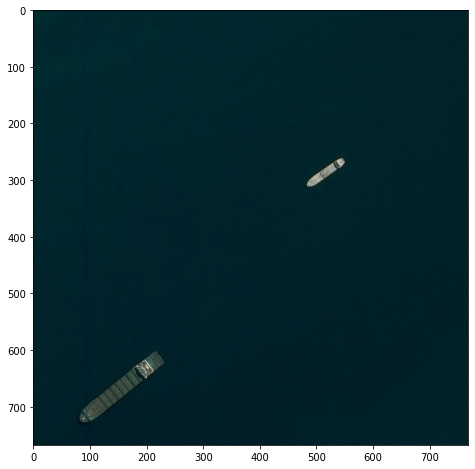

In [8]:
# Let us now see how it works for Image id:- 0005d01c8.jpg we have in the mask data frame

# Original image from training set
img_arr = imread(train_image_dir + '/' + '0005d01c8.jpg')
plt.figure(figsize=(15,8))
plt.imshow(img_arr)
plt.show()

In [9]:
img_arr.shape

(768, 768, 3)

In [10]:
# Filter out all 0005d01c8.jpg image ids and respective encoded data 
# 2 ships means 2 same image ids will be there!
rle_0 = masks.query('ImageId=="0005d01c8.jpg"')['EncodedPixels']
rle_0

29    56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
30    365871 1 366638 3 367405 6 368173 7 368940 9 3...
Name: EncodedPixels, dtype: object

In [11]:
# Make a list of each mask shown above also visualise whats happening!
mask_lst, ct = [], 1
for mask in rle_0:
    print(f"Mask {ct} -\n{mask}\n\n")
    mask_lst.append(mask)
    ct+=1

Mask 1 -
56010 1 56777 3 57544 6 58312 7 59079 9 59846 11 60613 14 61380 16 62148 17 62915 19 63682 22 64449 24 65216 26 65984 27 66751 30 67518 32 68285 34 69052 36 69820 38 70587 40 71354 42 72121 42 72888 42 73656 42 74423 42 75190 42 75957 42 76724 42 77492 42 78259 42 79026 42 79793 42 80560 42 81328 42 82095 42 82862 42 83629 42 84396 42 85164 42 85931 42 86698 42 87465 42 88232 42 89000 42 89767 42 90534 42 91301 42 92068 42 92836 42 93603 42 94370 42 95137 42 95904 42 96672 42 97439 42 98206 42 98973 42 99740 42 100508 42 101275 42 102042 42 102809 42 103576 42 104344 42 105111 42 105878 42 106645 42 107412 42 108180 42 108947 42 109714 42 110481 42 111249 41 112016 42 112783 42 113550 42 114317 42 115085 41 115852 42 116619 42 117386 42 118153 42 118921 41 119688 42 120455 42 121222 42 121989 42 122757 41 123524 42 124291 42 125058 42 125825 42 126593 42 127360 42 128127 42 128894 42 129661 42 130429 42 131196 42 131963 42 132730 42 133497 42 134265 42 135032 42 135799 42 1365

In [12]:
# Split and Display how the first mask in the list looks like
split = mask_lst[0].split()
print(split)

['56010', '1', '56777', '3', '57544', '6', '58312', '7', '59079', '9', '59846', '11', '60613', '14', '61380', '16', '62148', '17', '62915', '19', '63682', '22', '64449', '24', '65216', '26', '65984', '27', '66751', '30', '67518', '32', '68285', '34', '69052', '36', '69820', '38', '70587', '40', '71354', '42', '72121', '42', '72888', '42', '73656', '42', '74423', '42', '75190', '42', '75957', '42', '76724', '42', '77492', '42', '78259', '42', '79026', '42', '79793', '42', '80560', '42', '81328', '42', '82095', '42', '82862', '42', '83629', '42', '84396', '42', '85164', '42', '85931', '42', '86698', '42', '87465', '42', '88232', '42', '89000', '42', '89767', '42', '90534', '42', '91301', '42', '92068', '42', '92836', '42', '93603', '42', '94370', '42', '95137', '42', '95904', '42', '96672', '42', '97439', '42', '98206', '42', '98973', '42', '99740', '42', '100508', '42', '101275', '42', '102042', '42', '102809', '42', '103576', '42', '104344', '42', '105111', '42', '105878', '42', '10664

- This data shows start_pixels and lenghts where we can think ship to exist in the original image.
- For example, 56777 3 shows that pixels 56777, 56778, 56779 contributes to the ship.
- Our target is to create an image with these pixels labeled as 1 and remaining as 0.
- This is how we can produce a mask for respective image.

In [13]:
# Grab all the starting pixels and lenghts and convert it into integers using numpy 
starts, lengths = [np.array(x, dtype = int) for x in (split[::2], split[1::2])]
starts, lengths

(array([ 56010,  56777,  57544,  58312,  59079,  59846,  60613,  61380,
         62148,  62915,  63682,  64449,  65216,  65984,  66751,  67518,
         68285,  69052,  69820,  70587,  71354,  72121,  72888,  73656,
         74423,  75190,  75957,  76724,  77492,  78259,  79026,  79793,
         80560,  81328,  82095,  82862,  83629,  84396,  85164,  85931,
         86698,  87465,  88232,  89000,  89767,  90534,  91301,  92068,
         92836,  93603,  94370,  95137,  95904,  96672,  97439,  98206,
         98973,  99740, 100508, 101275, 102042, 102809, 103576, 104344,
        105111, 105878, 106645, 107412, 108180, 108947, 109714, 110481,
        111249, 112016, 112783, 113550, 114317, 115085, 115852, 116619,
        117386, 118153, 118921, 119688, 120455, 121222, 121989, 122757,
        123524, 124291, 125058, 125825, 126593, 127360, 128127, 128894,
        129661, 130429, 131196, 131963, 132730, 133497, 134265, 135032,
        135799, 136566, 137333, 138101, 138868, 139635, 140402, 

In [14]:
# Get the ending pixels. 
'''Examples:- 
56010 1 ---> Starts at 56010 and ends at 56010
56777 3 ---> Starts at 56777 and ends at 56779
57544 6 ---> Starts at 57544 and ends at 57549'''
ends = starts + lengths - 1
pd.DataFrame({
    'Starts' : starts,
    'Lengths' : lengths,
    'Ends' : ends
}).head(10)

,Starts,Lengths,Ends
0,56010,1,56010
1,56777,3,56779
2,57544,6,57549
3,58312,7,58318
4,59079,9,59087
5,59846,11,59856
6,60613,14,60626
7,61380,16,61395
8,62148,17,62164
9,62915,19,62933


In [15]:
# Create 1s in place of these pixels and rest should be 0
img = np.zeros(768*768, dtype = np.uint8)
for start, end in zip(starts, ends):
    img[start:end+1] = 1

In [16]:
# Check how output looks
img[56776:56781] # Should output 0, 1 , 1, 1 ,0 as we know 56777, 56778, 56779 ---> 1 and 5676, 56780 ---> 0

array([0, 1, 1, 1, 0], dtype=uint8)

In [17]:
# Copy-Paste this idea for another ship in the image
split_1 = mask_lst[1].split()                                                                # Split the mask into start_pixels and lengths
starts, lengths = [np.array(x, dtype = int) for x in (split_1[0:][::2], split_1[1:][::2])]   # Generate arrays from only starts and lengths
ends = starts + lengths - 1                                                                  # Start pixel to end pixel will be start - 1 + length
img1 = np.zeros(768*768, dtype = np.uint8)                                                   # 1D array containing all zeros
for start, end in zip(starts, ends):                                                         # For each start to end pair
    img1[start:end+1] = 1                                                                    # Convert the values from 0 to 1

In [18]:
# Reshaping both the ship masks and combining it to form the final mask!
img = img.reshape(768, 768)
img1 = img1.reshape(768, 768)
final = img+img1
print(final, '\n\n', final.shape, '\n\n', final.ndim)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

 (768, 768) 

 2


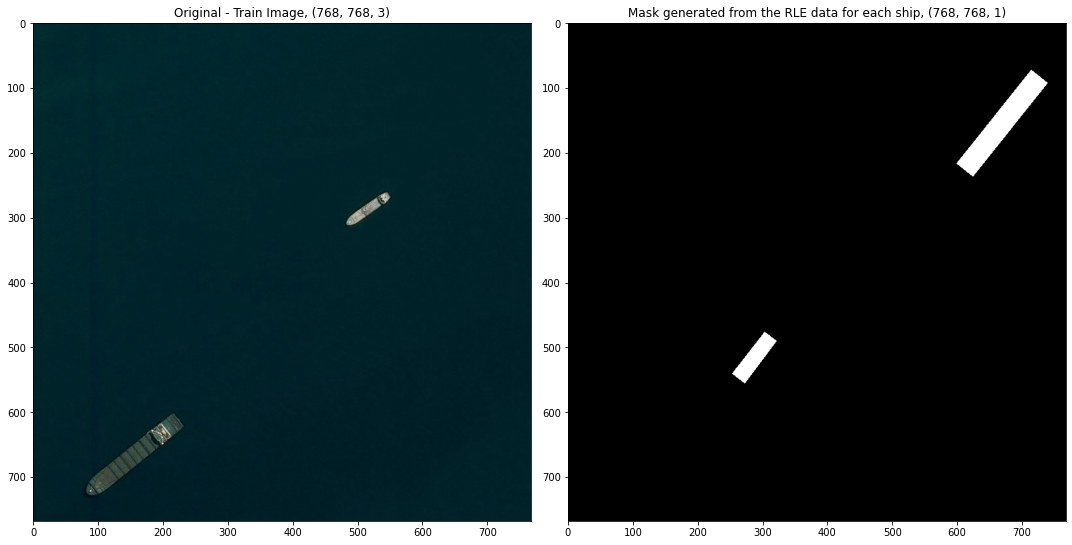

In [19]:
# Expand dimension of this array to have only 1 channel in the mask and visualise original and final mask
final = np.expand_dims(final, -1) # -1 means the last available dimenstion, in this case it is 2. Hence, on axis = 2 we will get 1.
original = imread(train_image_dir+'/'+train_images[15])
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "gray")
plt.tight_layout()
plt.show()

- Oh, something is off!
- Our mask needs to be transposed. 

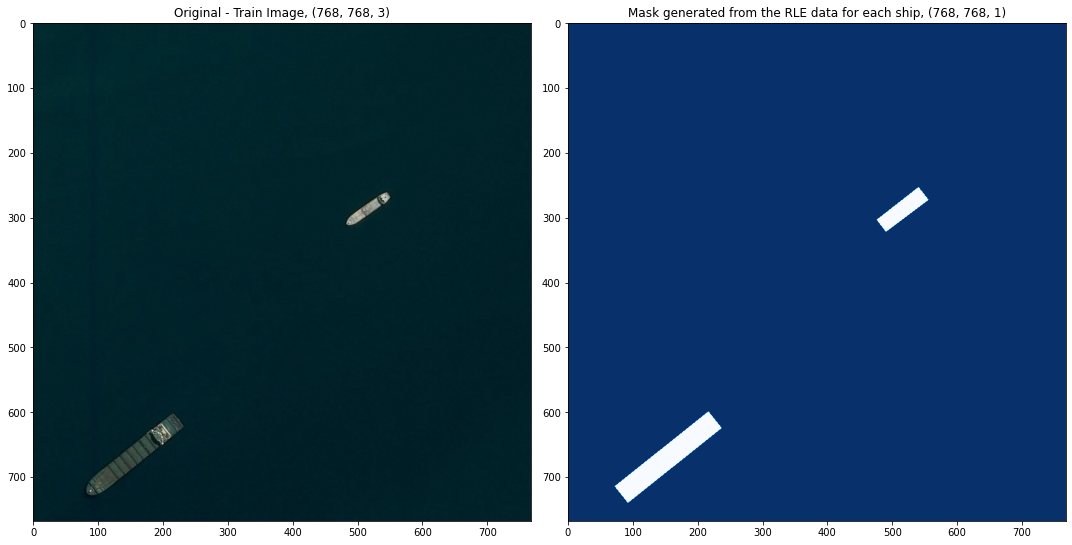

In [20]:
# Copy Paste the code from the prev cell with one change - Transpose!
img = img.reshape(768, 768).T     # Transpose the first ship mask
img1 = img1.reshape(768, 768).T   # Transpose the second ship mask
final = img+img1                  # Generate the final mask with two ships 
final = np.expand_dims(final, -1) 
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image, {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship, {final.shape}")
plt.imshow(final, cmap = "Blues_r")
plt.tight_layout()
plt.show()

- So this is how the EncodedPixels data for one image id looks like!
- We can build a function that can quickly generate such masks for all the EncodedPixels wrt to its ImageId.

In [21]:
# Define functions to do these tasks for all the training images
def rle_decode(mask_rle, shape=(768,768)):
    '''
    Input arguments -
    mask_rle: Mask of one ship in the train image
    shape: Output shape of the image array
    '''
    s = mask_rle.split()                                                               # Split the mask of each ship that is in RLE format
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]     # Get the start pixels and lengths for which image has ship
    ends = starts + lengths - 1                                                        # Get the end pixels where we need to stop
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)                                  # A 1D vec full of zeros of size = 768*768
    for lo, hi in zip(starts, ends):                                                   # For each start to end pixels where ship exists
        img[lo:hi+1] = 1                                                               # Fill those values with 1 in the main 1D vector
    '''
    Returns -
    Transposed array of the mask: Contains 1s and 0s. 1 for ship and 0 for background
    '''
    return img.reshape(shape).T                                                       

def masks_as_image(in_mask_list):
    '''
    Input - 
    in_mask_list: List of the masks of each ship in one whole training image
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)                                 # Creating 0s for the background
    for mask in in_mask_list:                                                          # For each ship rle data in the list of mask rle 
        if isinstance(mask, str):                                                      # If the datatype is string
            all_masks += rle_decode(mask)                                              # Use rle_decode to create one mask for whole image
    '''
    Returns - 
    Full mask of the training image whose RLE data has been passed as an input
    '''
    return np.expand_dims(all_masks, -1)

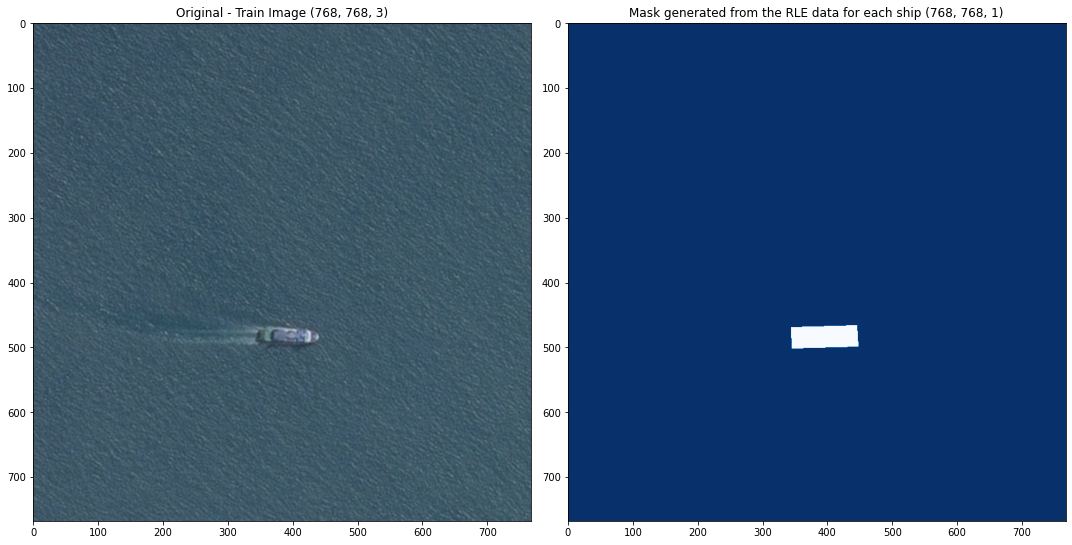

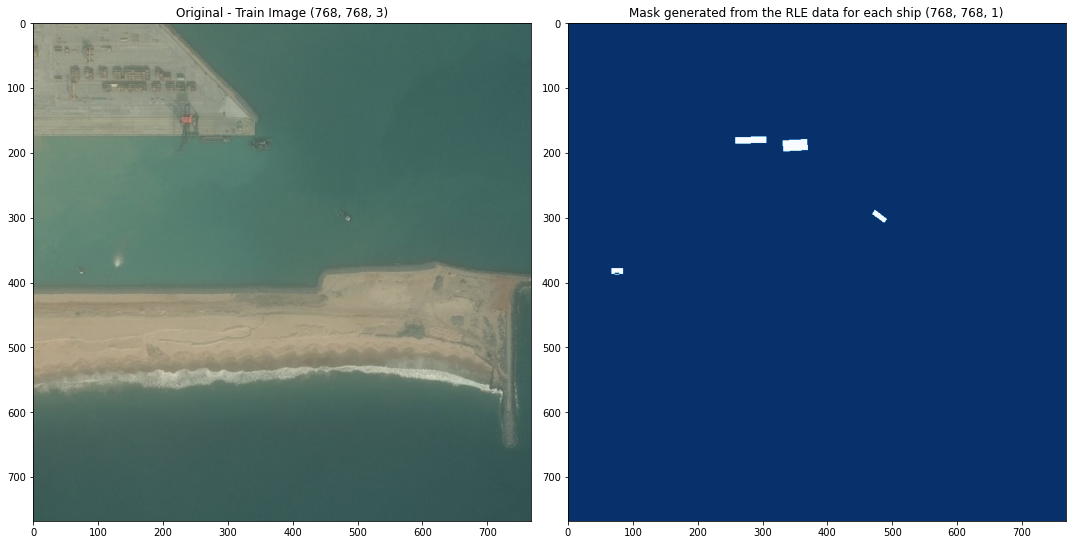

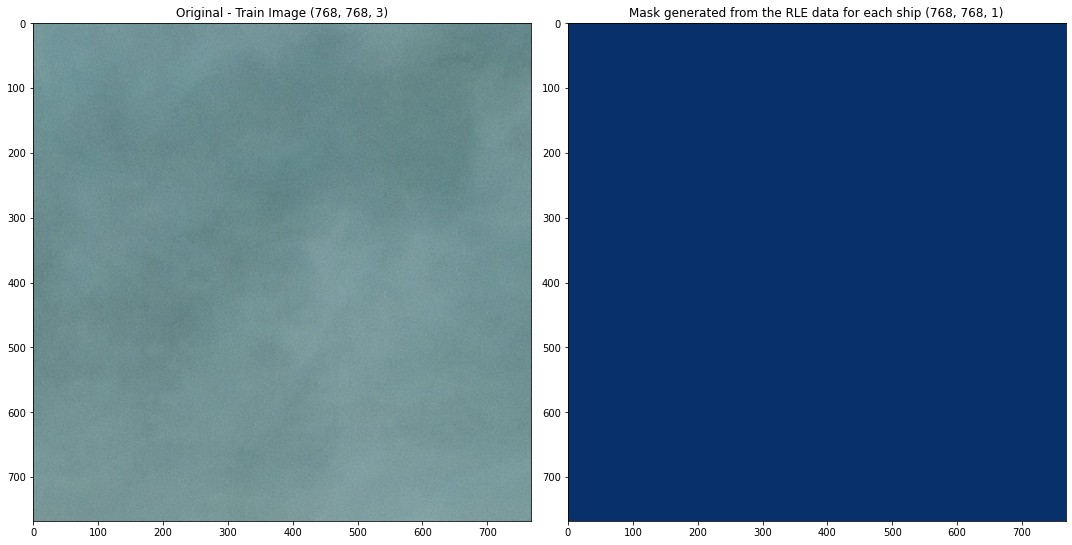

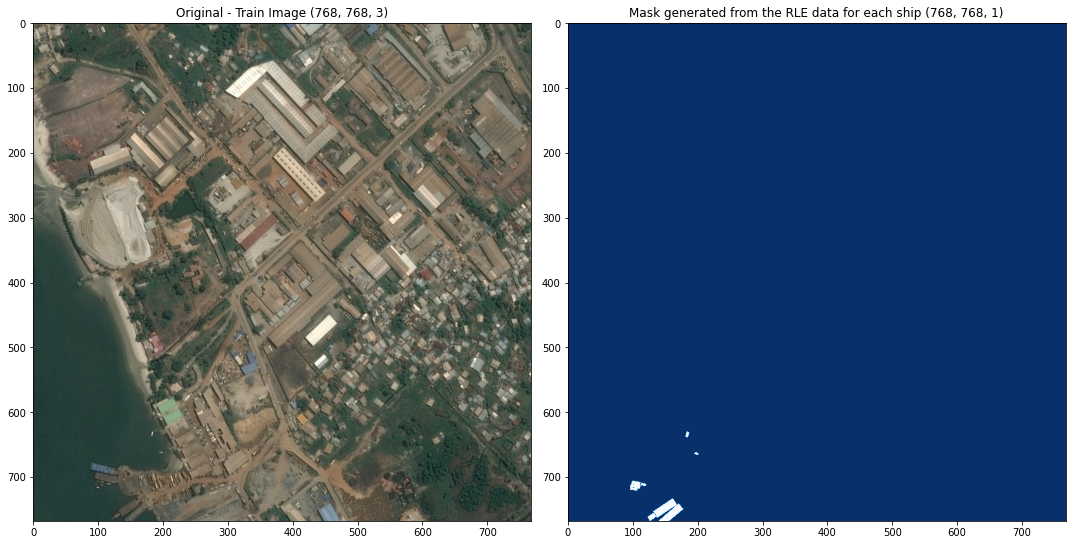

In [22]:
for num in [3, 4, 5, 6]:
    rle_0 = masks.query(f'ImageId=="{train_images[num-1]}"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    original = imread(train_image_dir+"/"+train_images[num-1])
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - Train Image {original.shape}")
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.title(f"Mask generated from the RLE data for each ship {final.shape}")
    plt.imshow(img_0, cmap = "Blues_r")
    plt.tight_layout()
    plt.show()

- We have succesfully constructed some functions that will take in the rle data and convert it into mask!
- We can now begin with spliting the data into train and validation.

## Preparing Train and Validation Data <a class="anchor"  id="h5"></a>

In [23]:
'''Note that NaN values in the EncodedPixels are of float type and everything else is a string type'''   

# Add a new feature to the masks data frame named as ship. If Encoded pixel in any row is a string, there is a ship else there isn't. 
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head(9)

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,1
8,0001b1832.jpg,NaN,0


In [24]:
# Making a new data frame with unique image ids where we are summing up the ship counts
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index() 
unique_img_ids.index+=1 # Incrimenting all the index by 1
unique_img_ids.head()

,ImageId,ships
1,00003e153.jpg,0
2,0001124c7.jpg,0
3,000155de5.jpg,1
4,000194a2d.jpg,5
5,0001b1832.jpg,0


In [25]:
# Adding two new features to unique_img_ids data frame. If ship exists in image, val is 1 else 0. And it's vec form
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids.head()

,ImageId,ships,has_ship
1,00003e153.jpg,0,0.0
2,0001124c7.jpg,0,0.0
3,000155de5.jpg,1,1.0
4,000194a2d.jpg,5,1.0
5,0001b1832.jpg,0,0.0


In [26]:
# Check the size of the files. Will take some time to run as there are loads of files!!!
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
'''os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'''

'os.stat is used to get status of the specified path. Here, st_size represents size of the file in bytes. Converting it into kB!'

In [27]:
# We can get rid of any images whose size is less than 35 Kb. As some of the files are corrupted! 
unique_img_ids[unique_img_ids.file_size_kb<35].head()

,ImageId,ships,has_ship,file_size_kb
85,001bfb70a.jpg,0,0.0,22.796875
359,0080bd6a5.jpg,0,0.0,14.327148
819,011589d1f.jpg,0,0.0,20.317383
1434,01df54887.jpg,0,0.0,16.492188
2342,0318fc519.jpg,0,0.0,13.289062


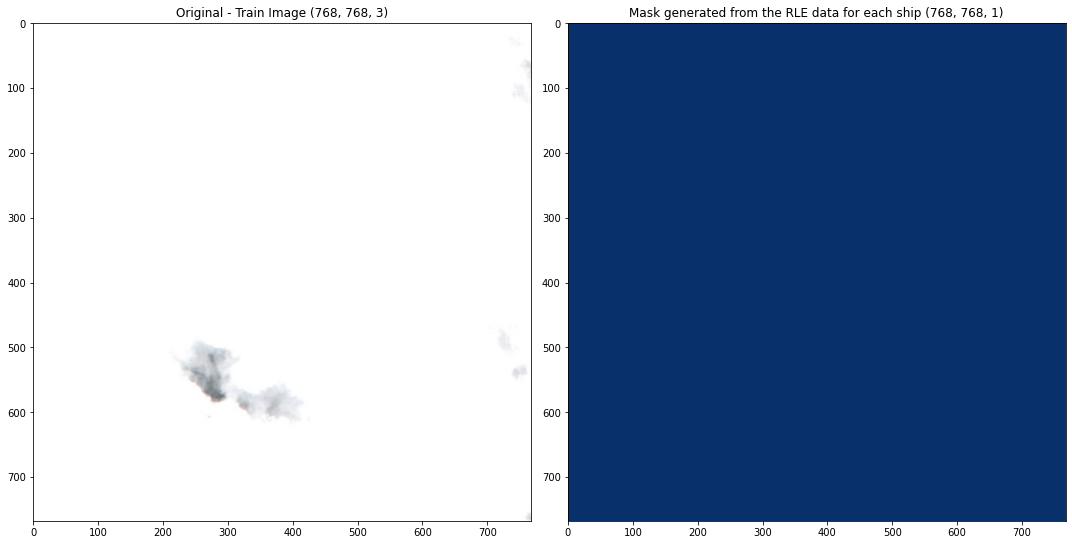

In [28]:
rle_0 = masks.query(f'ImageId=="0318fc519.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
original = imread(train_image_dir+"/"+'0318fc519.jpg')
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original - Train Image {original.shape}")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title(f"Mask generated from the RLE data for each ship {final.shape}")
plt.imshow(img_0, cmap = "Blues_r")
plt.tight_layout()
plt.show()

In [29]:
# Keep the files whose size > 35 kB
unique_img_ids = unique_img_ids[unique_img_ids.file_size_kb > 35]
unique_img_ids.head()

,ImageId,ships,has_ship,file_size_kb
1,00003e153.jpg,0,0.0,128.944336
2,0001124c7.jpg,0,0.0,76.059570
3,000155de5.jpg,1,1.0,147.625977
4,000194a2d.jpg,5,1.0,75.221680
5,0001b1832.jpg,0,0.0,95.627930


In [30]:
# Also, retrive the old masks data frame
masks.drop(['ships'], axis=1, inplace=True)
masks.index+=1 
masks.head()

,ImageId,EncodedPixels
1,00003e153.jpg,NaN
2,0001124c7.jpg,NaN
3,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
4,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
5,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


- Now, its the time to use the train_test_split.
- Stratify to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

In [31]:
# Train - Test split
from sklearn.model_selection import train_test_split                   
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.3, stratify = unique_img_ids['ships'])

In [32]:
# Create train data frame
train_df = pd.merge(masks, train_ids)

# Create test data frame
valid_df = pd.merge(masks, valid_ids)

In [33]:
print("There are ~")
print(train_df.shape[0], 'training masks,')
print(valid_df.shape[0], 'validation masks.')

There are ~
162039 training masks,
69447 validation masks.


In [34]:
# # Visualise the ship counts
# plt.figure(figsize=(10, 6))
# sns.countplot(train_df.ships)
# plt.show()

- Oh!! Very huge imbalance in the data...
- We need to have a better balanced data!!!

## Random Undersampling to generate a better balanced data to work with

In [35]:
# Clipping the max value of grouped_ship_count to be 7, minimum to be 0
train_df['grouped_ship_count'] = train_df.ships.map(lambda x: (x+1)//2).clip(0,7)

In [36]:
# Check
train_df.grouped_ship_count.value_counts()

0    104837
1     29713
2     10744
3      6000
4      3772
5      2710
6      2155
7      2108
Name: grouped_ship_count, dtype: int64

#### Difference between head(n) and sample(n) in pandas
- df.head(n) returns only top n data from the df
- df.sample(n) returns random n data from the df

In [37]:
# Top 10 data
train_df.head(10)

,ImageId,EncodedPixels,ships,has_ship,file_size_kb,grouped_ship_count
0,0001124c7.jpg,NaN,0,0.0,76.059570,0
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5,1.0,75.221680,3
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5,1.0,75.221680,3
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5,1.0,75.221680,3
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,5,1.0,75.221680,3
5,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,5,1.0,75.221680,3
6,0001b1832.jpg,NaN,0,0.0,95.627930,0
7,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9,1.0,242.910156,5
8,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9,1.0,242.910156,5
9,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...,9,1.0,242.910156,5


In [38]:
# Random 10 data
train_df.sample(10)

,ImageId,EncodedPixels,ships,has_ship,file_size_kb,grouped_ship_count
24195,262762213.jpg,135686 3 136450 7 137214 11 137978 16 138742 2...,2,1.0,97.050781,1
82350,81adb794c.jpg,159309 2 160075 4 160841 7 161607 9 162373 12 ...,8,1.0,142.394531,4
28173,2c578b52f.jpg,362761 1 363529 2 364296 5 365064 6 365831 9 3...,3,1.0,141.673828,2
87464,89dabb628.jpg,NaN,0,0.0,132.907227,0
159779,fc4a04e18.jpg,NaN,0,0.0,201.668945,0
160115,fcde9328f.jpg,NaN,0,0.0,85.674805,0
46061,488c64726.jpg,59119 1 59885 4 60652 5 61419 7 62185 9 62952 ...,7,1.0,126.679688,4
31737,321522f54.jpg,NaN,0,0.0,130.119141,0
8166,0c990c916.jpg,NaN,0,0.0,143.804688,0
29381,2e264fc0b.jpg,NaN,0,0.0,172.916992,0


In [39]:
# Random Under-Sampling ships
def sample_ships(in_df, base_rep_val=1500):
    '''
    Input Args:
    in_df - dataframe we want to apply this function
    base_val - random sample of this value to be taken from the data frame
    '''
    if in_df['ships'].values[0]==0:                                                 
        return in_df.sample(base_rep_val//3)  # Random 1500//3 = 500 samples taken whose ship count is 0 in an image 
    else:                                 
        return in_df.sample(base_rep_val)    # Random 1500 samples taken whose ship count is not 0 in an image

In [40]:
# Creating groups of ship counts and applying the sample_ships functions to randomly undersample the ships
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df.grouped_ship_count.value_counts() # In each group we have total of 1500 ships except 0 as we have decreased it even more to 500

7    1500
6    1500
5    1500
4    1500
3    1500
2    1500
1    1500
0     500
Name: grouped_ship_count, dtype: int64

In [41]:
# Explaining what we just did if still not clear
for i in range(8):
    df_val_counts = balanced_train_df[balanced_train_df.grouped_ship_count==i].ships.value_counts()
    print(f"Data frame for grouped ship count = {i}:-\n{df_val_counts}\nSum of Values:- {df_val_counts.values.sum()}\n\n")


Data frame for grouped ship count = 0:-
0    500
Name: ships, dtype: int64
Sum of Values:- 500


Data frame for grouped ship count = 1:-
1    964
2    536
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 2:-
3    876
4    624
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 3:-
5    821
6    679
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 4:-
7    777
8    723
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 5:-
9     837
10    663
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 6:-
11    767
12    733
Name: ships, dtype: int64
Sum of Values:- 1500


Data frame for grouped ship count = 7:-
14    526
15    493
13    481
Name: ships, dtype: int64
Sum of Values:- 1500




In [42]:
# plt.figure(figsize = (15, 5))
# plt.suptitle("Train Data", fontsize = 18, color = 'r', weight = 'bold')
# plt.subplot(1, 2, 1)
# import seaborn as sns
# sns.countplot(train_df.ships, palette = 'Set2')
# plt.title("Ship Counts - Before Balancing", color = 'm', fontsize = 15)
# plt.ylabel("Count", color = 'tab:pink', fontsize = 13)
# plt.xlabel("# Ships in an image", color = 'tab:pink', fontsize = 13)
# plt.subplot(1, 2, 2)
# sns.countplot(balanced_train_df.ships, palette = 'Set2')
# plt.title("Ship Counts - After Balancing", color = 'm', fontsize = 15)
# plt.xlabel("# Ships in an image", color = 'tab:pink', fontsize = 13)
# plt.tight_layout()

In [43]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.10.0rc0, 2.10.0rc1, 2.10.0)
ERROR: No matching distribution found for keras==2.5


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import montage
from skimage.segmentation import mark_boundaries

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import keras.backend as K

import segmentation_models as sm

# Parameters
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 100
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
NET_SCALING = None
IMG_SCALING = (1, 1)
VALID_IMG_COUNT = 400
MAX_TRAIN_STEPS = 2
BACKBONE = 'efficientnetb0'

Segmentation Models: using `tf.keras` framework.


Using TensorFlow backend.


In [45]:
# Image and Mask Generator
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    '''
    Inputs -
    in_df - data frame on which the function will be applied
    batch_size - number of training examples in one iteration
    '''
    all_batches = list(in_df.groupby('ImageId'))                             # Group ImageIds and create list of that dataframe
    out_rgb = []                                                             # Image list
    out_mask = []                                                            # Mask list
    while True:                                                              # Loop for every data
        np.random.shuffle(all_batches)                                       # Shuffling the data
        for c_img_id, c_masks in all_batches:                                # For img_id and msk_rle in all_batches
            rgb_path = os.path.join(train_image_dir, c_img_id)               # Get the img path
            c_img = imread(rgb_path)                                         # img array
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)         # Create mask of rle data for each ship in an img
            out_rgb += [c_img]                                               # Append the current img in the out_rgb / img list
            out_mask += [c_mask]                                             # Append the current mask in the out_mask / mask list
            if len(out_rgb)>=batch_size:                                     # If length of list is more or equal to batch size then
                yield np.stack(out_rgb)/255.0, np.stack(out_mask)            # Yeild the scaled img array (b/w 0 and 1) and mask array (0 for bg and 1 for ship)
                out_rgb, out_mask=[], []                                     # Empty the lists to create another batch

In [46]:
# Generate train data 
train_gen = make_image_gen(balanced_train_df)

# Image and Mask
train_x, train_y = next(train_gen)

# Print the summary
print(f"train_x ~\nShape: {train_x.shape}\nMin value: {train_x.min()}\nMax value: {train_x.max()}")
print(f"\ntrain_y ~\nShape: {train_y.shape}\nMin value: {train_y.min()}\nMax value: {train_y.max()}")

train_x ~
Shape: (4, 768, 768, 3)
Min value: 0.0
Max value: 1.0

train_y ~
Shape: (4, 768, 768, 1)
Min value: 0
Max value: 1


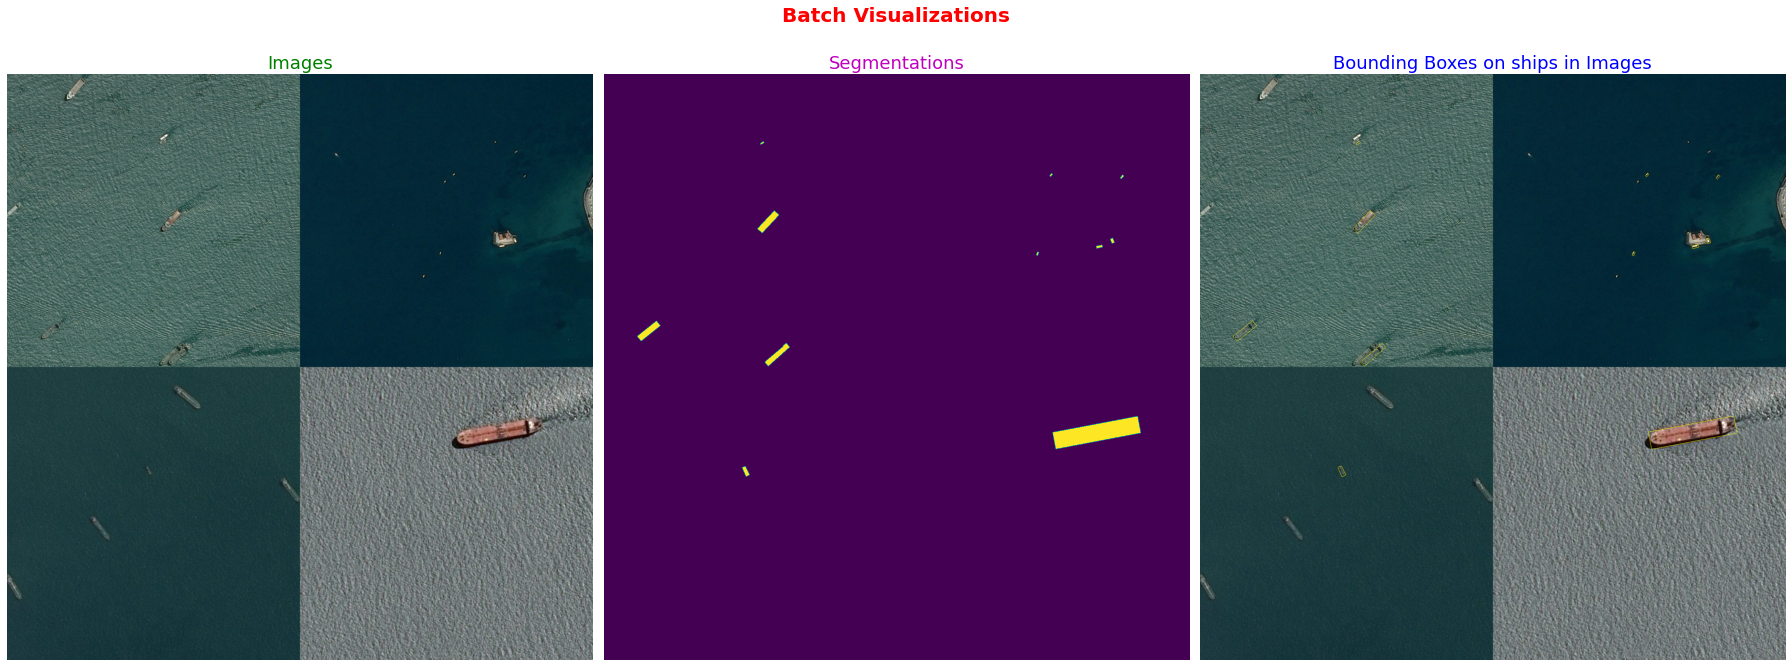

In [47]:
# Visulaising train batch
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
batch_rgb = montage_rgb(train_x)                                                   # Create montage of img
batch_seg = montage(train_y[:, :, :, 0])                                           # Create montafe of msk
batch_overlap = mark_boundaries(batch_rgb, batch_seg.astype(int))                  # Create bounding box around ships in img
titles = ["Images", "Segmentations", "Bounding Boxes on ships in Images"]          # Titles for subplot
colors = ['g', 'm', 'b']                                                           # Colors to be used for title
display = [batch_rgb, batch_seg, batch_overlap]                                    # What to display in subplot
plt.figure(figsize=(25,10))                                                        # Generate figure 
for i in range(3):                                                                 # For i = 0, 1, 2, 3                           
    plt.subplot(1, 3, i+1)                                                         # Create subplot
    plt.imshow(display[i])                                                         # Display 
    plt.title(titles[i], fontsize = 18, color = colors[i])                         # Title 
    plt.axis('off')                                                                # Turn off the axis
plt.suptitle("Batch Visualizations", fontsize = 20, color = 'r', weight = 'bold')  # Add suptitle
plt.tight_layout()                                                                 # Layout for subplot

In [48]:
# Prepare validation data
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(f"valid_x ~\nShape: {valid_x.shape}\nMin value: {valid_x.min()}\nMax value: {valid_x.max()}")
print(f"\nvalid_y ~\nShape: {valid_y.shape}\nMin value: {valid_y.min()}\nMax value: {valid_y.max()}")

valid_x ~
Shape: (400, 768, 768, 3)
Min value: 0.0
Max value: 1.0

valid_y ~
Shape: (400, 768, 768, 1)
Min value: 0
Max value: 1


In [49]:
# Augmenting Data using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparing image data generator arguments
dg_args = dict(rotation_range = 15,            # Degree range for random rotations
               horizontal_flip = True,         # Randomly flips the inputs horizontally
               vertical_flip = True,           # Randomly flips the inputs vertically
               data_format = 'channels_last')  # channels_last refer to (batch, height, width, channels)

In [50]:
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    '''
    Takes in -
    in_gen - train data generator, seed value
    '''
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))  # Randomly assign seed value if not provided
    for in_x, in_y in in_gen:                                                    # For imgs and msks in train data generator
        seed = 12                                                                # Seed value for imgs and msks must be same else augmentation won't be same
        
        # Create augmented imgs
        g_x = image_gen.flow(255*in_x,                                           # Inverse scaling on imgs for augmentation                                       
                             batch_size = in_x.shape[0],                         # batch_size = 3
                             seed = seed,                                        # Seed
                             shuffle=True)                                       # Shuffle the data
        
        # Create augmented masks
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],                       
                             seed = seed,                                         
                             shuffle=True)                                       
        
        '''Yeilds - augmented scaled imgs and msks array'''
        yield next(g_x)/255.0, next(g_y)

In [51]:
# Augment the train data
cur_gen = create_aug_gen(train_gen, seed = 42)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


In [52]:
# Preprocess input for efficientnetb0
preprocess_input = sm.get_preprocessing(BACKBONE)
train_x = preprocess_input(train_x)
valid_x = preprocess_input(valid_x)

In [53]:
BACKBONE = 'efficientnetb0'
efficientnetb0_unet = sm.Unet(BACKBONE, input_shape=(None, None, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')
efficientnetb0_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [54]:
# # Final display before passing data into model
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25, 10))
# ax1.imshow(montage_rgb(t_x), cmap='gray')
# ax1.set_title('Images', fontsize = 18, color = 'g')
# ax1.axis('off')
# ax2.imshow(montage(t_y[:, :, :, 0]), cmap='Blues_r')
# ax2.set_title('Masks', fontsize = 18, color = 'r')
# ax2.axis('off')
# ax3.imshow(mark_boundaries(montage_rgb(t_x), montage(t_y[:, :, :, 0].astype(int))))
# ax3.set_title('Bounding Box', fontsize = 18, color = 'b')
# ax3.axis('off')
# plt.tight_layout()

In [55]:
gc.collect() # Block all the garbage that has been generated

1232

In [56]:
# # Build U-Net model
# from keras import models, layers

# # Conv2DTranspose upsampling
# def upsample_conv(filters, kernel_size, strides, padding):
#     return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
# # Upsampling without Conv2DTranspose
# def upsample_simple(filters, kernel_size, strides, padding):
#     return layers.UpSampling2D(strides)

# # Upsampling method choice
# if UPSAMPLE_MODE=='DECONV':
#     upsample=upsample_conv
# else:
#     upsample=upsample_simple

# # Building the layers of UNET
# input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
# pp_in_layer = input_img

# # If NET_SCALING is defined then do the next step else continue ahead
# if NET_SCALING is not None:
#     pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

# # To avoid overfitting and fastening the process of training
# pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)                       # Useful to mitigate overfitting
# pp_in_layer = layers.BatchNormalization()(pp_in_layer)                                # Allows using higher learning rate without causing problems with gradients


# ## Downsample (C-->C-->MP)

# c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
# c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
# p1 = layers.MaxPooling2D((2, 2)) (c1)

# c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
# c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
# p2 = layers.MaxPooling2D((2, 2)) (c2)

# c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
# c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
# p3 = layers.MaxPooling2D((2, 2)) (c3)

# c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
# c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
# p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


# c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
# c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# ## Upsample (U --> Concat --> C --> C)

# u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
# u6 = layers.concatenate([u6, c4])
# c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
# c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

# u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
# u7 = layers.concatenate([u7, c3])
# c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
# c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

# u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
# u8 = layers.concatenate([u8, c2])
# c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
# c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

# u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = layers.concatenate([u9, c1], axis=3)
# c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
# c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

# d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

# if NET_SCALING is not None:
#     d = layers.UpSampling2D(NET_SCALING)(d)

# efficientnetb0_unet = models.Model(inputs=[input_img], outputs=[d])

# efficientnetb0_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [57]:
# Compute dice coefficient, loss with BCE and compile the model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# Dice Coefficient
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Dice with BCE Loss
def dice_p_bce(y_true, y_pred):
    # Binary Cross-Entropy loss
    bce_loss = binary_crossentropy(y_true, y_pred)
    
    # Dice coefficient loss
    dice_loss = 1 - dice_coef(y_true, y_pred)
    
    # Combined loss
    alpha = 1e-3
    combo_loss = bce_loss + alpha * dice_loss
    
    return combo_loss
# Compile the model
efficientnetb0_unet.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef])

In [58]:
# Preparing Callbacks
# Preparing Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Best model weights
weight_path = "{}_weights.best.weights.h5".format('efficientnetb0_unet')
print(type(weight_path))
# Monitor validation dice coeff and save the best model weights
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

# Reduce Learning Rate on Plateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, verbose=1, mode='max', 
                                   min_delta=0.0001, cooldown=2, min_lr=1e-6)

# Stop training once there is no improvement seen in the model
early = EarlyStopping(monitor="val_dice_coef", mode="max", patience=15)

# Callbacks ready
callbacks_list = [checkpoint, early, reduceLROnPlat]
print([type(callback) for callback in callbacks_list])


<class 'str'>
[<class 'keras.callbacks.callbacks.ModelCheckpoint'>, <class 'keras.callbacks.callbacks.EarlyStopping'>, <class 'keras.callbacks.callbacks.ReduceLROnPlateau'>]


In [59]:
# Finalizing steps per epoch
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0] // BATCH_SIZE)

# Final augmented data being used in training
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

# Save loss history while training
loss_history = [efficientnetb0_unet.fit(
                                        aug_gen, 
                                        steps_per_epoch=step_count, 
                                        epochs=NB_EPOCHS, 
                                        validation_data=(valid_x, valid_y),
                                        callbacks=callbacks_list,
                                        )]



Epoch 1/100
2/2 [==============================] - 323s 162s/step - loss: nan - dice_coef: nan - val_loss: nan - val_dice_coef: nan

Epoch 00001: val_dice_coef did not improve from -inf


AttributeError: 'TFOptimizer' object has no attribute 'learning_rate'

In [ ]:
# Save the weights to load it later for test data 
# efficientnetb0_unet.load_weights(weight_path)
efficientnetb0_unet.save('efficientnetb0_unet.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
import cv2

# Define custom objects (if any)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Correct the file path

# Load the trained model with custom objects
custom_objects = {'dice_coef': dice_coef}
# model = load_model(model_path, custom_objects=custom_objects)

# Define image dimensions and path to the test directory
IMG_HEIGHT = 768  # Change this to your image height
IMG_WIDTH = 768   # Change this to your image width
TEST_DIR = r'E:/test_v2'  # Use raw string literal for Windows paths
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix
import seaborn as sns

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    plt.figure()
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Flatten predictions and true labels
y_true = valid_y.flatten()
y_pred = efficientnetb0_unet.predict(valid_x).flatten()

# Plot ROC curve
plot_roc_curve(y_true, y_pred)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_true, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred)



In [ ]:
# Load the trained model with custom objects
custom_objects = {'dice_coef': dice_coef}

# Define image dimensions and path to the test directory
IMG_HEIGHT = 768  # Change this to your image height
IMG_WIDTH = 768   # Change this to your image width
TEST_DIR = r'E:/test_v2'  # Use raw string literal for Windows paths

# Define a function to load and preprocess test images
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    return img

# Define a function to post-process the predicted mask to extract bounding boxes
def get_bounding_boxes(prediction, threshold=0.15):
    prediction = prediction[0, :, :, 0]  # Extract the single channel
    prediction = (prediction > threshold).astype(np.uint8)  # Apply threshold to binarize
    contours, _ = cv2.findContours(prediction, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    return bounding_boxes

# Define a function to display the results
def display_results(image_name, test_image, prediction, bounding_boxes):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Test Image: {image_name}')
    plt.imshow(test_image[0])
    
    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(prediction[0, :, :, 0], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('Bounding Boxes')
    img_with_boxes = (test_image[0] * 255).astype(np.uint8)  # Convert back to uint8
    for box in bounding_boxes:
        x, y, w, h = box
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(img_with_boxes)
    
    plt.show()

# Iterate over all images in the test directory and display the results
for image_name in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image_name)
    
    # Load and preprocess the test image
    test_image = load_and_preprocess_image(image_path)
    
    # Make a prediction
    prediction = efficientnetb0_unet.predict(test_image)
    
    # Get bounding boxes from the prediction
    bounding_boxes = get_bounding_boxes(prediction)
    
    # Display the test image, predicted mask, and bounding boxes
    display_results(image_name, test_image, prediction, bounding_boxes)